In [1]:
# !tar -xzvf dataset.tar

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import cv2
from PIL import Image, ImageOps
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
# на каком устройстве будет выполняться обработка данных в PyTorch GPU или CPU

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [44]:
class HistogramEqualization(object):
    def __call__(self, img):
        return ImageOps.equalize(img)
    
    
class CLAHETransform:
    def __init__(self, clip_limit=2.0, tile_grid_size=(16, 16)):
        self.clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)

    def __call__(self, img):
        
        img = np.array(img)
        
        # переводим изображение в другой формат (L - яркость, A, B - цветовые каналы)
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        
        # изменяем яркость изображения и создаём новое
        l = self.clahe.apply(l)
        lab = cv2.merge((l, a, b))
        
        # перевод в исходный формат
        img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
        return Image.fromarray(img)
    
    
class ThresholdSegmentation(object):
    def __init__(self, threshold=140):
        self.threshold = threshold

    def __call__(self, img):
        img = np.array(img.convert("L"))
        # всё что ниже порога будет чёрным, всё что выше оставляем
        _, img = cv2.threshold(img, self.threshold, 255, cv2.THRESH_BINARY)
        return Image.fromarray(img)
    
    
class FourierTransformFilter(object):
    def __init__(self, low_freq_cutoff=0, high_freq_cutoff=255):
        # интервал оставляемых частот
        self.low_freq_cutoff = low_freq_cutoff
        self.high_freq_cutoff = high_freq_cutoff

    def __call__(self, img):
        
        img = np.array(img.convert("L"))
        # преобразовываем изображение в частотное представление
        f = np.fft.fft2(img)
        # для облегчения работы с частотами, перемещаем нулевые частоты к центру
        fshift = np.fft.fftshift(f)

        # определяем центр изображения
        rows, cols = img.shape
        crow, ccol = rows // 2 , cols // 2

        # создаем фильтр
        mask = np.zeros((rows, cols), np.uint8)
        mask[crow-self.high_freq_cutoff:crow+self.high_freq_cutoff, ccol-self.high_freq_cutoff:ccol+self.high_freq_cutoff] = 1
        mask[crow-self.low_freq_cutoff:crow+self.low_freq_cutoff, ccol-self.low_freq_cutoff:ccol+self.low_freq_cutoff] = 0

        # применяем фильтр к частотному спектру
        fshift = fshift * mask
        # обратное смещение
        f_ishift = np.fft.ifftshift(fshift)
        # обратное преобразование
        img_back = np.fft.ifft2(f_ishift)
        img_back = np.abs(img_back)

        return Image.fromarray(np.uint8(img_back))
    

class EdgeEnhancement(object):
    def __call__(self, img):
        img = np.array(img) 
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
        sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
        img = cv2.magnitude(sobel_x, sobel_y)
        img = np.uint8(img)
        return Image.fromarray(img)

In [93]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])# TODO: compose transforms here

train_dataset = datasets.ImageFolder('./dataset/classification/train/', transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = datasets.ImageFolder('./dataset/classification/test/', transform=transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

datasets_ = {'train': train_dataset, 'test': test_dataset}
dataloaders = {'train': train_dataloader, 'test': test_dataloader}
dataset_sizes = {'train': len(train_dataset), 'test': len(test_dataset)}

class_names = train_dataset.classes

In [83]:
# Инициализация сумм и счетчика
channel_sum = np.array([0, 0, 0])

num_pixels = 0

# Проход по всем батчам
for inputs, _ in train_dataloader:
    
    for i in range(inputs.size(0)):
        
        for j in range(3):
            channel_sum[j] += inputs[i][j].sum()
            
        
    num_pixels += inputs.size(0) * inputs.size(2) * inputs.size(3)

# Расчет средних
mean = channel_sum / num_pixels

channel_sum_squared = np.array([0, 0, 0])

for inputs, _ in train_dataloader:
    
    for i in range(inputs.size(0)):
        
        for j in range(3):
            channel_sum_squared[j] += (inputs[i][j] ** 2).sum() - mean[j]
            
# Расчет дисперсий
var = np.sqrt(channel_sum_squared / num_pixels)

print(f"Средние по каналам: {mean}")
print(f"Стандартное отклонение по каналам: {var}")

Средние по каналам: [0.50912495 0.50912495 0.50912495]
Стандартное отклонение по каналам: [0.3268618 0.3268618 0.3268618]


In [94]:
def imshow(image, ax=None, title=None, normalize=False):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.535425].


<Axes: >

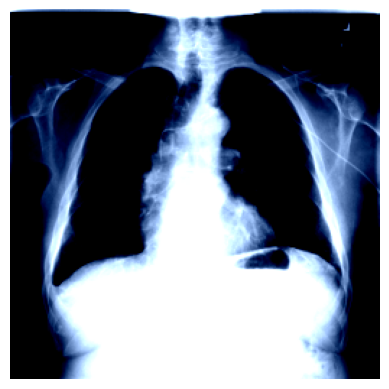

In [95]:
# Run this to test your data loader
images, labels = next(iter(train_dataloader))
# helper.imshow(images[0], normalize=False)
imshow(images[0], normalize=False)

In [96]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'test']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'test' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

In [97]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(20, 13))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//4, 4, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}, real: {class_names[labels[j]]}')
                imshow(inputs.cpu().data[j], ax=ax)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [90]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [98]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=12)

Epoch 0/11
----------
train Loss: 0.0184 Acc: 1.0000
test Loss: 2.1089 Acc: 0.3953

Epoch 1/11
----------
train Loss: 0.0146 Acc: 1.0000
test Loss: 2.1294 Acc: 0.4084

Epoch 2/11
----------
train Loss: 0.0122 Acc: 1.0000
test Loss: 2.1235 Acc: 0.4058

Epoch 3/11
----------
train Loss: 0.0133 Acc: 1.0000
test Loss: 2.1399 Acc: 0.4058

Epoch 4/11
----------
train Loss: 0.0113 Acc: 1.0000
test Loss: 2.1488 Acc: 0.4110

Epoch 5/11
----------
train Loss: 0.0099 Acc: 1.0000
test Loss: 2.1289 Acc: 0.3979

Epoch 6/11
----------
train Loss: 0.0097 Acc: 1.0000
test Loss: 2.1494 Acc: 0.4110

Epoch 7/11
----------
train Loss: 0.0116 Acc: 1.0000
test Loss: 2.1271 Acc: 0.4136

Epoch 8/11
----------
train Loss: 0.0114 Acc: 1.0000
test Loss: 2.1353 Acc: 0.4031

Epoch 9/11
----------
train Loss: 0.0092 Acc: 1.0000
test Loss: 2.1650 Acc: 0.4136

Epoch 10/11
----------
train Loss: 0.0087 Acc: 1.0000
test Loss: 2.1502 Acc: 0.3979

Epoch 11/11
----------
train Loss: 0.0104 Acc: 1.0000
test Loss: 2.1555 Acc

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5005665].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.169412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5005665].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.465708].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.3611329].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.57

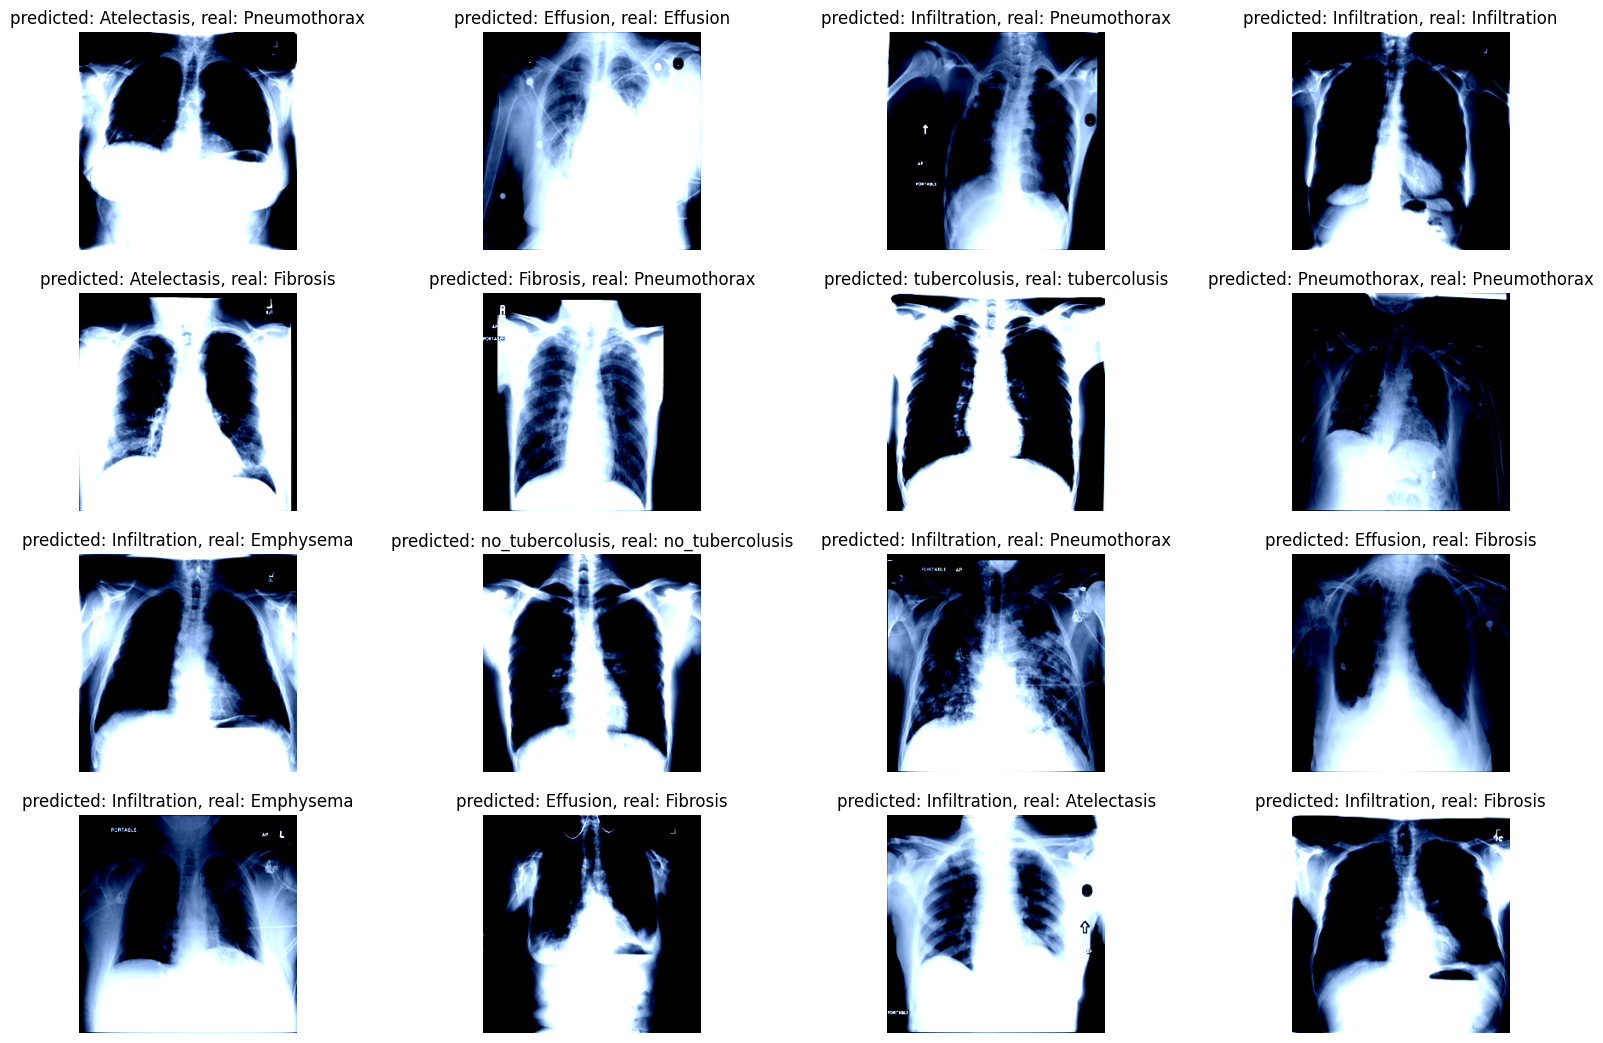

In [59]:
visualize_model(model_ft, num_images=16)